# 01 Import Libraries

In [1]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
import importlib

In [6]:
%reload_ext autoreload
%autoreload 2

In [8]:
import lib
importlib.reload(lib)

<module 'lib' from '/content/Learning-the-Optimal-Solution-Path/lib/__init__.py'>

In [9]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.ngs.loss_fn import reg_exp_weighted_logit
from lib.ngs.log_reg_module import Logistic_Regression
from lib.ngs.solver import train, test

# 02 Instantiate Variables




In [10]:
# file path for Colab. May need to change this
X_df = pd.read_csv('X_processed.csv')
y_df = pd.read_csv('y_processed.csv')

In [11]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [12]:
X_tune = X[:200, :]
y_tune = y[:200]

In [13]:
train_X = torch.tensor(X_tune, dtype=torch.float32)
train_y = torch.tensor(y_tune, dtype=torch.float32)

In [14]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=True, )
# test data
test_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=False, )

In [15]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]

In [16]:
loss_fn = reg_exp_weighted_logit

In [17]:
lr_list = 0.5 ** np.arange(-2, 11)
beta_list = 0.5 ** np.arange(-4, 11)

# 03 Define Functions

In [18]:
def gen_loss_gd(lam, lr):

    weight = torch.zeros(input_dim)
    intercept = 0
    model = Logistic_Regression(input_dim, 1, lam, weight, intercept).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()
    itr = 0
    for t in range(100):
        itr, weight, intercept = train(itr, weight, intercept, GD_data_loader,
                                       model, loss_fn, optimizer, device)

    loss = test(test_data_loader, model, loss_fn, lam, device)

    return loss

# 04 Tuning lr

Pick lr = 1

In [21]:
lam = 7

In [22]:
losses = []
for lr in lr_list:
    loss = gen_loss_gd(lam, lr)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 4.0	 loss: 1.0060943365097046
learning rate: 2.0	 loss: 0.18644055724143982
learning rate: 1.0	 loss: 0.15865491330623627
learning rate: 0.5	 loss: 0.15865492820739746
learning rate: 0.25	 loss: 0.15865491330623627
learning rate: 0.125	 loss: 0.1586623340845108
learning rate: 0.0625	 loss: 0.15898385643959045
learning rate: 0.03125	 loss: 0.16096718609333038
learning rate: 0.015625	 loss: 0.16518287360668182
learning rate: 0.0078125	 loss: 0.17033779621124268
learning rate: 0.00390625	 loss: 0.17640429735183716
learning rate: 0.001953125	 loss: 0.18513649702072144
learning rate: 0.0009765625	 loss: 0.19665467739105225


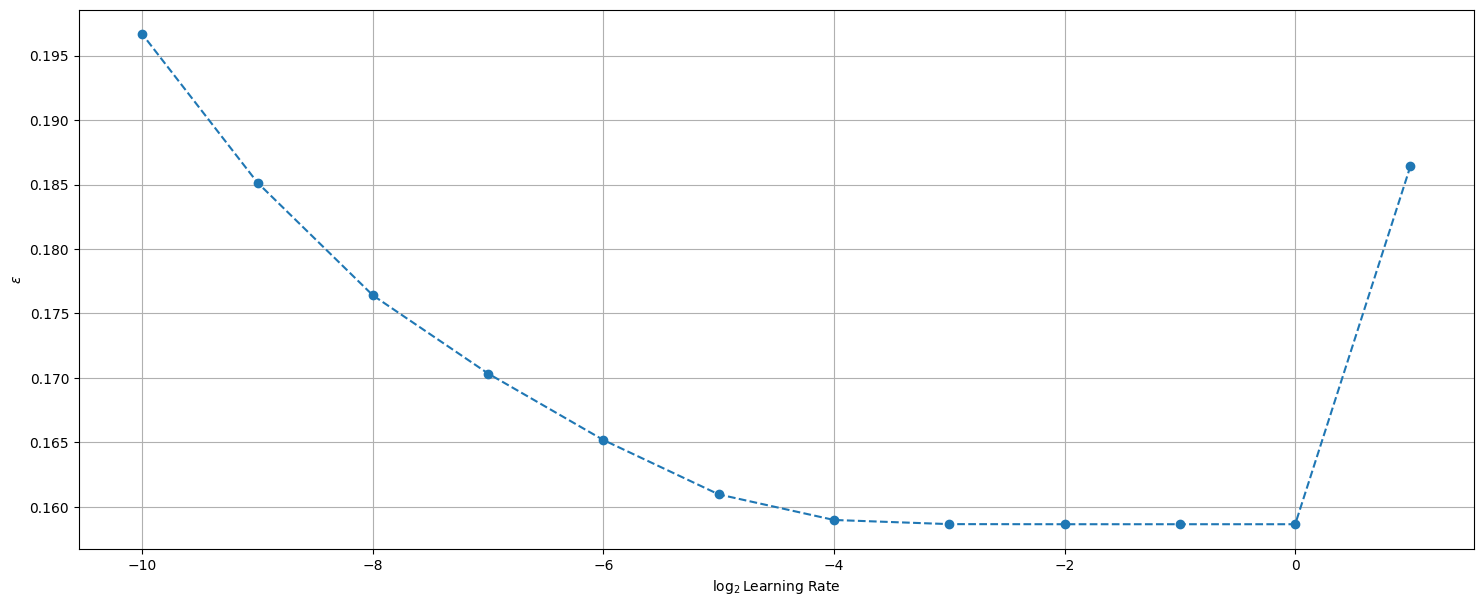

In [23]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[1:]), losses[1:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)